In [1]:
import pandas as pd 

data = pd.read_csv('data_no_bg.csv')

data.loc[data['malade'] == False, 'nom_maladie'] = 'healthy'

data['malade'] = data['malade'].astype(int)
data['malade'] = data['malade'].astype(str)

data.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,1,Apple_scab
1,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,1,Apple_scab
2,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,1,Apple_scab
3,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,1,Apple_scab
4,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,1,Apple_scab


### Création d'un échantillon 

In [2]:
class_counts = data['nom_maladie'].value_counts()
species_counts = data['espece'].value_counts()
sick_counts = data['malade'].value_counts()

# Calcul du nombre d'images à prélever
num_images_per_class = round(1500 / len(class_counts))
num_images_per_species = round(1500 / len(species_counts))
num_images_sick = round(2000 / len(sick_counts))

# Création des échantillons équilibrés
sample = pd.DataFrame()
for class_name, count in class_counts.items():
    samples = data[data['nom_maladie'] == class_name].sample(min(count, num_images_per_class), random_state=42)
    sample = sample.append(samples)

for species_name, count in species_counts.items():
    samples = data[data['espece'] == species_name].sample(min(count, num_images_per_species), random_state=42)
    sample = sample.append(samples)

for sick_value, count in sick_counts.items():
    samples = data[data['malade'] == sick_value].sample(min(count, num_images_sick), random_state=42)
    sample = sample.append(samples)

# Mélange aléatoire
sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\aissa\AppData\Local\Temp\ipykernel_68632\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_68632\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_68632\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_68632\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_68632\3821067970

In [3]:
sample

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Grape,1,Esca_(Black_Measles)
1,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Tomato,1,Early_blight
2,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,1,Apple_scab
3,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Strawberry,1,Leaf_scorch
4,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Soybean,0,healthy
...,...,...,...,...
4984,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,0,healthy
4985,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,1,Apple_scab
4986,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Potato,1,Late_blight
4987,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Tomato,1,Tomato_Yellow_Leaf_Curl_Virus


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [5]:
# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(sample.malade.unique())

num_classes

2

### Prétraitement des données

In [6]:
# Normalisation des pixels

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [7]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="malade",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='binary',
    subset='training'
)

Found 3992 validated image filenames belonging to 2 classes.


In [8]:
validation_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="malade",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

Found 997 validated image filenames belonging to 2 classes.


### Modélisation sur l'échantillon

In [9]:
# CNN

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
# Compilation du modèle

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Entraînement du modèle

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/8
62/62 [==============================] - 175s 3s/step - loss: 0.9773 - accuracy: 0.6645 - val_loss: 0.6914 - val_accuracy: 0.6969
Epoch 2/8
62/62 [==============================] - 178s 3s/step - loss: 0.6296 - accuracy: 0.7335 - val_loss: 0.5815 - val_accuracy: 0.7615
Epoch 3/8
62/62 [==============================] - 180s 3s/step - loss: 0.5597 - accuracy: 0.7716 - val_loss: 0.5653 - val_accuracy: 0.7667
Epoch 4/8
62/62 [==============================] - 183s 3s/step - loss: 0.5569 - accuracy: 0.7727 - val_loss: 0.5493 - val_accuracy: 0.7802
Epoch 5/8
62/62 [==============================] - 181s 3s/step - loss: 0.5027 - accuracy: 0.7930 - val_loss: 0.5184 - val_accuracy: 0.7708
Epoch 6/8
62/62 [==============================] - 176s 3s/step - loss: 0.5154 - accuracy: 0.7890 - val_loss: 0.5867 - val_accuracy: 0.8031
Epoch 7/8
62/62 [==============================] - 176s 3s/step - loss: 0.5006 - accuracy: 0.7971 - val_loss: 0.5023 - val_accuracy: 0.8042
Epoch 8/8
62/62 [===

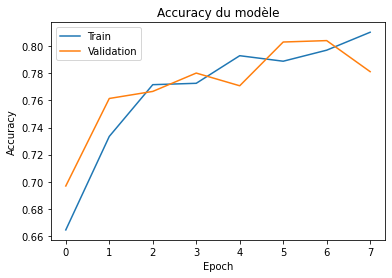

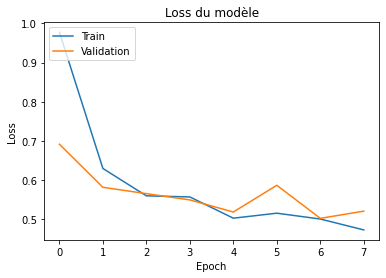

In [12]:
import matplotlib.pyplot as plt

# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Généralisation à l'ensemble du dataset

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Division du jeu de données en 10 dataframes équilibrés

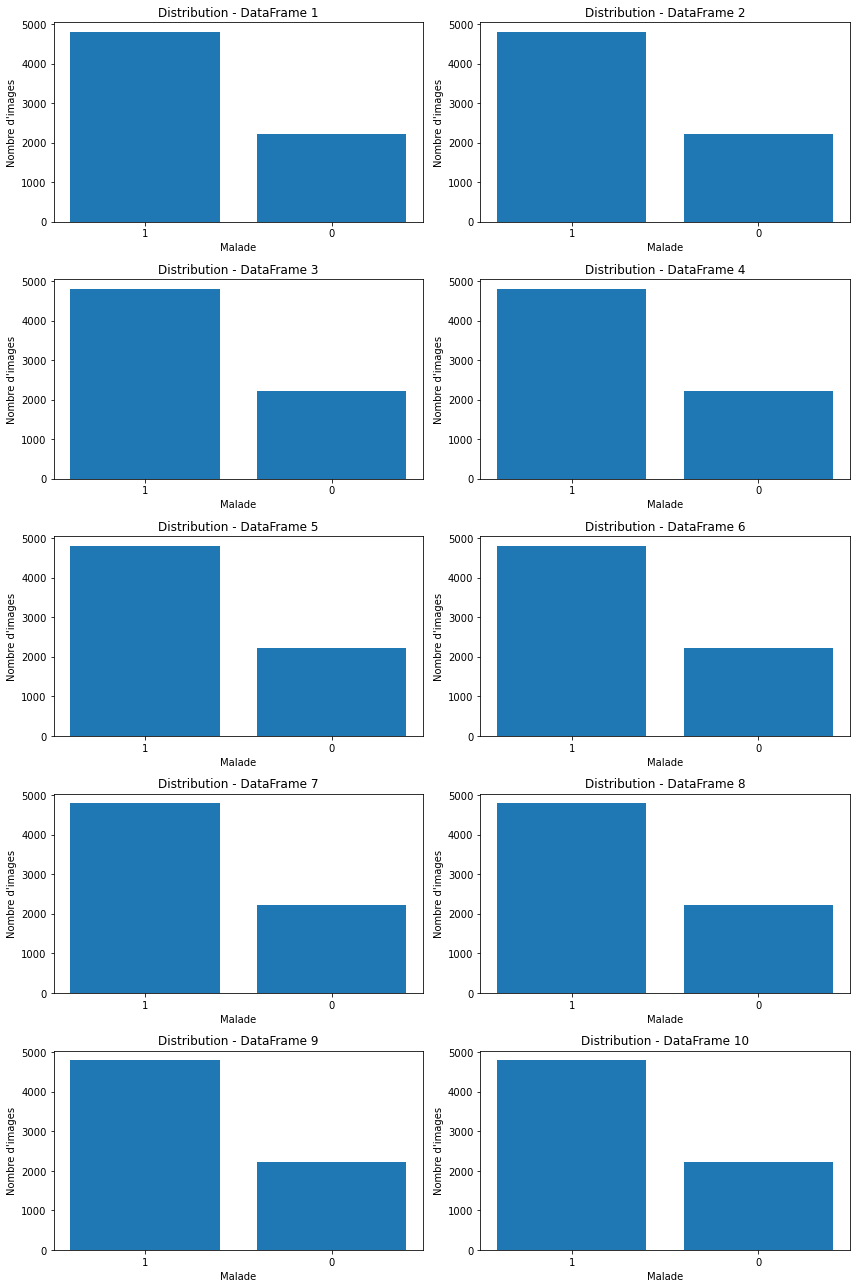

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['malade']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)
for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['malade'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("Malade")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [15]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="malade",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='binary',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="malade",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='binary',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated image filenames belonging to 2 classes.
Found 1405 validated image filenames belonging to 2 classes.
Found 5624 validated ima

### Modélisation 

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    'cnn_id_malade_no_bg.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(10):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 0.9811 - accuracy: 0.6969
Epoch 1: val_loss improved from inf to 0.68041, saving model to cnn_id_malade_no_bg.h5
87/87 [==============================] - 255s 3s/step - loss: 0.9811 - accuracy: 0.6969 - val_loss: 0.6804 - val_accuracy: 0.7783
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.7784
Epoch 2: val_loss improved from 0.68041 to 0.55081, saving model to cnn_id_malade_no_bg.h5
87/87 [==============================] - 246s 3s/step - loss: 0.5846 - accuracy: 0.7784 - val_loss: 0.5508 - val_accuracy: 0.7894
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.7885
Epoch 3: val_loss did not improve from 0.55081
87/87 [==============================] - 246s 3s/step - loss: 0.5340 - accuracy: 0.7885 - val_loss: 0.5630 - val_accuracy: 0.7783
Epoch 4/8
87/87 [==============================] - ETA: 0s - loss: 0.

Epoch 4/8
87/87 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9495
Epoch 4: val_loss improved from 0.24298 to 0.23675, saving model to cnn_id_malade_no_bg.h5
87/87 [==============================] - 244s 3s/step - loss: 0.2037 - accuracy: 0.9495 - val_loss: 0.2368 - val_accuracy: 0.9427
Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9477
Epoch 5: val_loss did not improve from 0.23675
87/87 [==============================] - 246s 3s/step - loss: 0.2099 - accuracy: 0.9477 - val_loss: 0.2995 - val_accuracy: 0.9100
Epoch 6/8
87/87 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9507
Epoch 6: val_loss did not improve from 0.23675
87/87 [==============================] - 245s 3s/step - loss: 0.2161 - accuracy: 0.9507 - val_loss: 0.2385 - val_accuracy: 0.9427
Epoch 7/8
87/87 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9628
Epoch 7: val_loss did not improve from 0.23675
87/87 

87/87 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9788
Epoch 8: val_loss did not improve from 0.20002
87/87 [==============================] - 243s 3s/step - loss: 0.1415 - accuracy: 0.9788 - val_loss: 0.2916 - val_accuracy: 0.9286
Fin de l'entraînement du modèle pour data_7.

Entraînement du modèle pour data_8 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9374
Epoch 1: val_loss did not improve from 0.20002
87/87 [==============================] - 247s 3s/step - loss: 0.2471 - accuracy: 0.9374 - val_loss: 0.2291 - val_accuracy: 0.9464
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9547
Epoch 2: val_loss did not improve from 0.20002
87/87 [==============================] - 243s 3s/step - loss: 0.1924 - accuracy: 0.9547 - val_loss: 0.2526 - val_accuracy: 0.9360
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9678
Epoch 3: val_loss did no

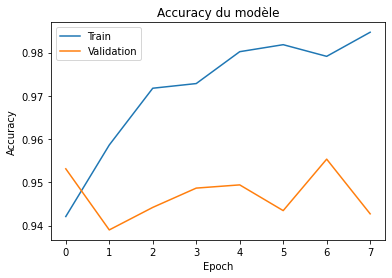

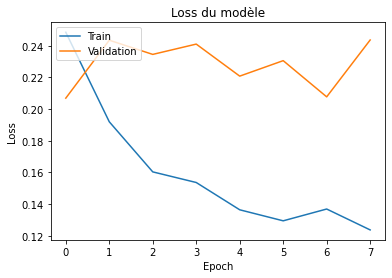

In [19]:
# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Sauvegarde du modèle

In [20]:
# Chargement du modèle 

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.load_weights('cnn_id_malade_no_bg.h5')

# Compilation 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_cnn_id_malade_no_bg.h5')